In [61]:
from astropy.table import Table
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
glob('catalogs/*')

['catalogs/hlsp_candels_hst_wfc3_egs-tot-multiband_f160w_v1_cat.fits',
 'catalogs/hlsp_candels_hst_wfc3_egs_v1_mass_cat.fits',
 'catalogs/hlsp_candels_hst_wfc3_egs_v1_photoz_cat.fits',
 'catalogs/hlsp_candels_hst_wfc3_egs_v1_physpar_cat.fits']

In [7]:
Mass = Table.read(fits.open('catalogs/hlsp_candels_hst_wfc3_egs_v1_mass_cat.fits')[1], format = 'fits').to_pandas()
Photz = Table.read(fits.open('catalogs/hlsp_candels_hst_wfc3_egs_v1_photoz_cat.fits')[1], format = 'fits').to_pandas()
Physpar = Table.read(fits.open('catalogs/hlsp_candels_hst_wfc3_egs_v1_physpar_cat.fits')[1], format = 'fits').to_pandas()
Cat = Table.read(fits.open('catalogs/hlsp_candels_hst_wfc3_egs-tot-multiband_f160w_v1_cat.fits')[1], format = 'fits').to_pandas()

In [43]:
np.array(Photz.columns)

array(['ID', 'Photo_z_Median', 'Photo_z_Salvato', 'Photo_z_Mobasher',
       'Photo_z_Finkelstein', 'Photo_z_Barro', 'Photo_z_Wiklind',
       'Photo_z_Wuyts', 'D95', 'Spec_z', 'Photo_z_lower_68',
       'Photo_z_upper_68', 'Photo_z_lower_95', 'Photo_z_upper_95'], dtype=object)

In [47]:
uvjDF = pd.DataFrame({'id' : Cat['ID'] ,'ra' : Cat['RA'],'dec' : Cat['DEC'], 'photz' : Photz['Photo_z_Median'],
                      'u' : Physpar['UMag_6a_deltau'] ,'v' : Physpar['VMag_6a_deltau']  ,'j' : Physpar['JMag_6a_deltau'],
                      'u-v' : Physpar['UMag_6a_deltau'] - Physpar['VMag_6a_deltau'] ,'v-j': Physpar['VMag_6a_deltau'] - Physpar['JMag_6a_deltau'],
                      'class_star' : Cat['CLASS_STAR'],'ssfr' : Physpar['SFR_6a_deltau'] / 10**Mass['M_med'],
                      'lmass' : Mass['M_med'] ,'H' : Cat['WFC3_F160W_FLUX']})

In [48]:
uvjDF = uvjDF[uvjDF.class_star < 0.8]
uvjDF = uvjDF[uvjDF.lmass > 10.0 ]
uvjDF = uvjDF[uvjDF.photz > 1.5 ]

In [49]:
qsflag = np.repeat('s',repeats=len(uvjDF.index))

for i in range(len(qsflag)):
    if uvjDF['u-v'].values[i]>=0.88*uvjDF['v-j'].values[i]+0.59 and uvjDF['u-v'].values[i]>1.382 and uvjDF['v-j'].values[i]<1.65:
        qsflag[i] = 'q'
        
uvjDF['SF'] = qsflag
qDF = uvjDF[uvjDF.SF == 'q']
sDF = uvjDF[uvjDF.SF == 's']

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


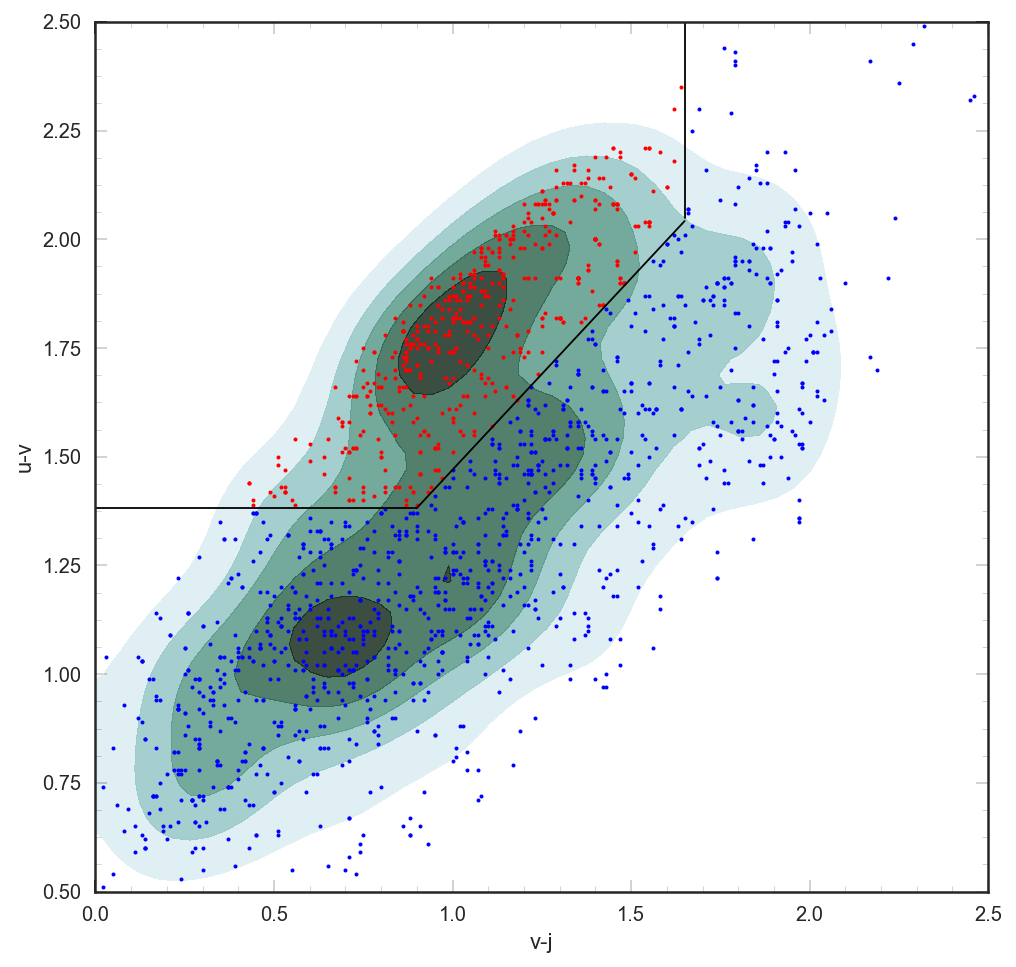

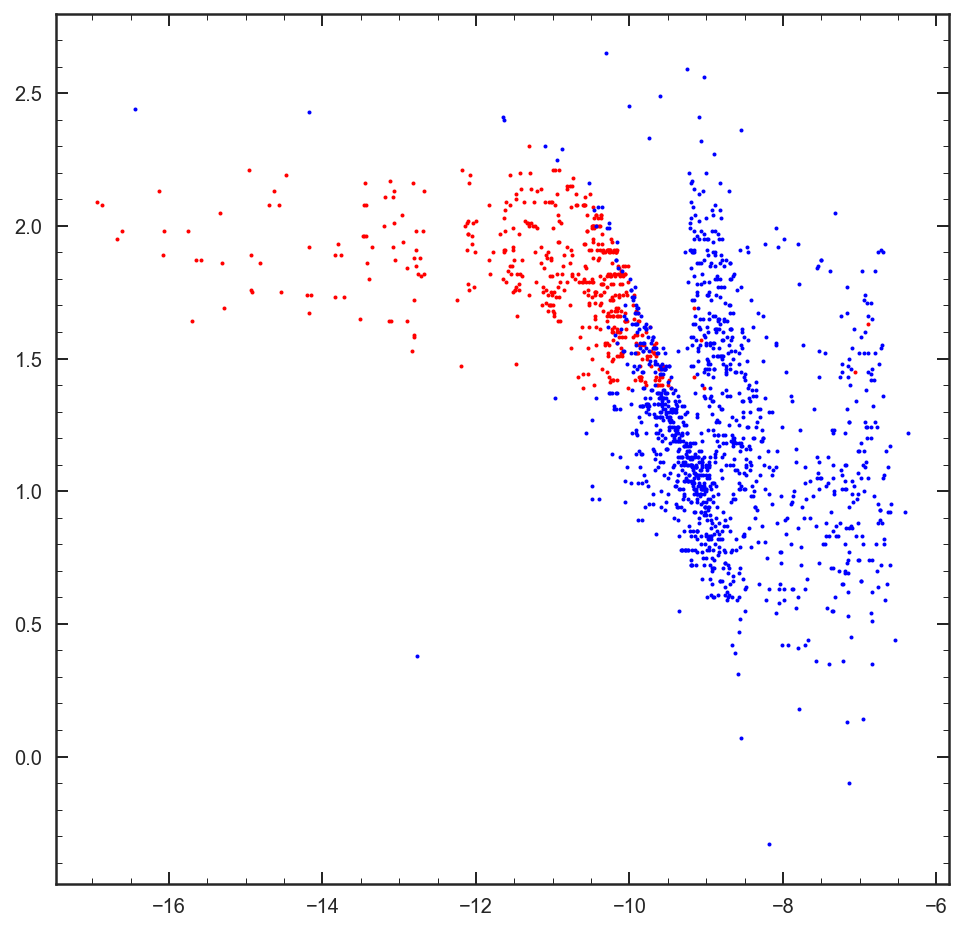

In [52]:
plt.figure(figsize=[8,8])
sea.kdeplot(uvjDF['v-j'],uvjDF['u-v'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)
plt.plot(qDF['v-j'],qDF['u-v'],'ro',ms=2)
plt.plot(sDF['v-j'],sDF['u-v'],'bo',ms=2)
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])


plt.figure(figsize=[8,8])
plt.plot(np.log10(qDF['ssfr']),qDF['u-v'],'ro',ms=2)
plt.plot(np.log10(sDF['ssfr']),sDF['u-v'],'bo',ms=2)


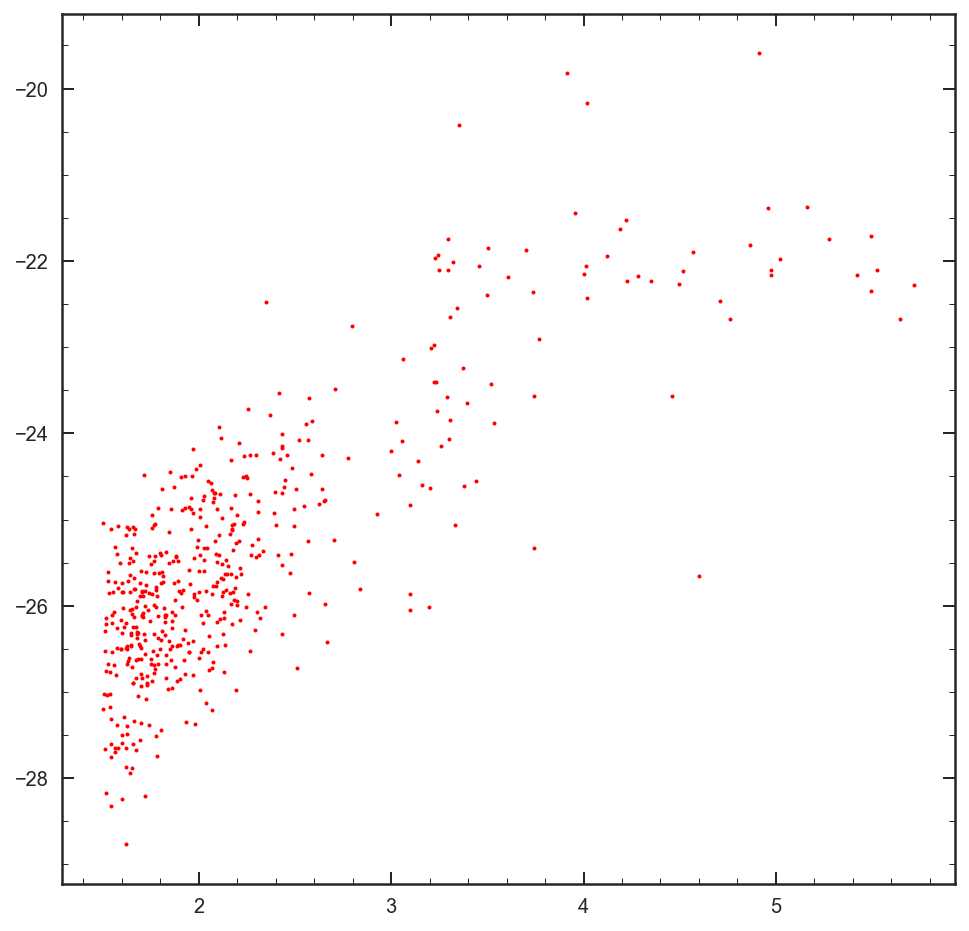

In [55]:
plt.figure(figsize=[8,8])
plt.plot(qDF['photz'], -2.5*np.log10(qDF['H'])-25 ,'ro',ms=2)


In [110]:
def ra_dec_convert(ra,dec):
    # ra - [hours,minutes,seconds]
    # dec - [degrees,arcminutes,arcseconds]
    
    RA = 15*(ra[0]+ ra[1]/60. + ra[2]/60./60.) 
    DEC = dec[0] + dec[1]/60. + dec[2]/60./60. 
    
    return RA,DEC

In [131]:
hsm_ra_dec = np.array([[[14,20,26.54], [52,57,15.7]],
              [[14,20,09.36], [52,57,34.0]],
              [[14,20,04.32], [52,53,30.4]],
              [[14,19,47.04], [52,53,45.4]]])
              
P = []
for i in range(len(hsm_ra_dec)):
    ra,dec = ra_dec_convert(hsm_ra_dec[i][0],hsm_ra_dec[i][1])
    P.append([ra,dec])

In [117]:
P

[[215.11058333333335, 52.954361111111112],
 [215.03899999999999, 52.959444444444451],
 [215.01800000000003, 52.891777777777776],
 [214.946, 52.895944444444446]]

In [136]:
C =np.pi / 180.
alpha = 49.
theta = 90. - alpha
d=129./60/60
c=43./60/60

bR = - (d + c/2) * np.array([np.cos(theta*C),np.sin(theta*C)])
X = (d/2) * np.array([-np.cos(alpha*C),np.sin(alpha*C)])
tR = (c/2) * np.array([np.cos(theta*C),np.sin(theta*C)])

P = np.array([[215.111550,52.95528],[215.0390267,52.96011],[215.0186304,52.89246],[214.9465871,52.89689]])
sPb = P + bR + X
tPb = P + tR + X


(215.4, 214.5)

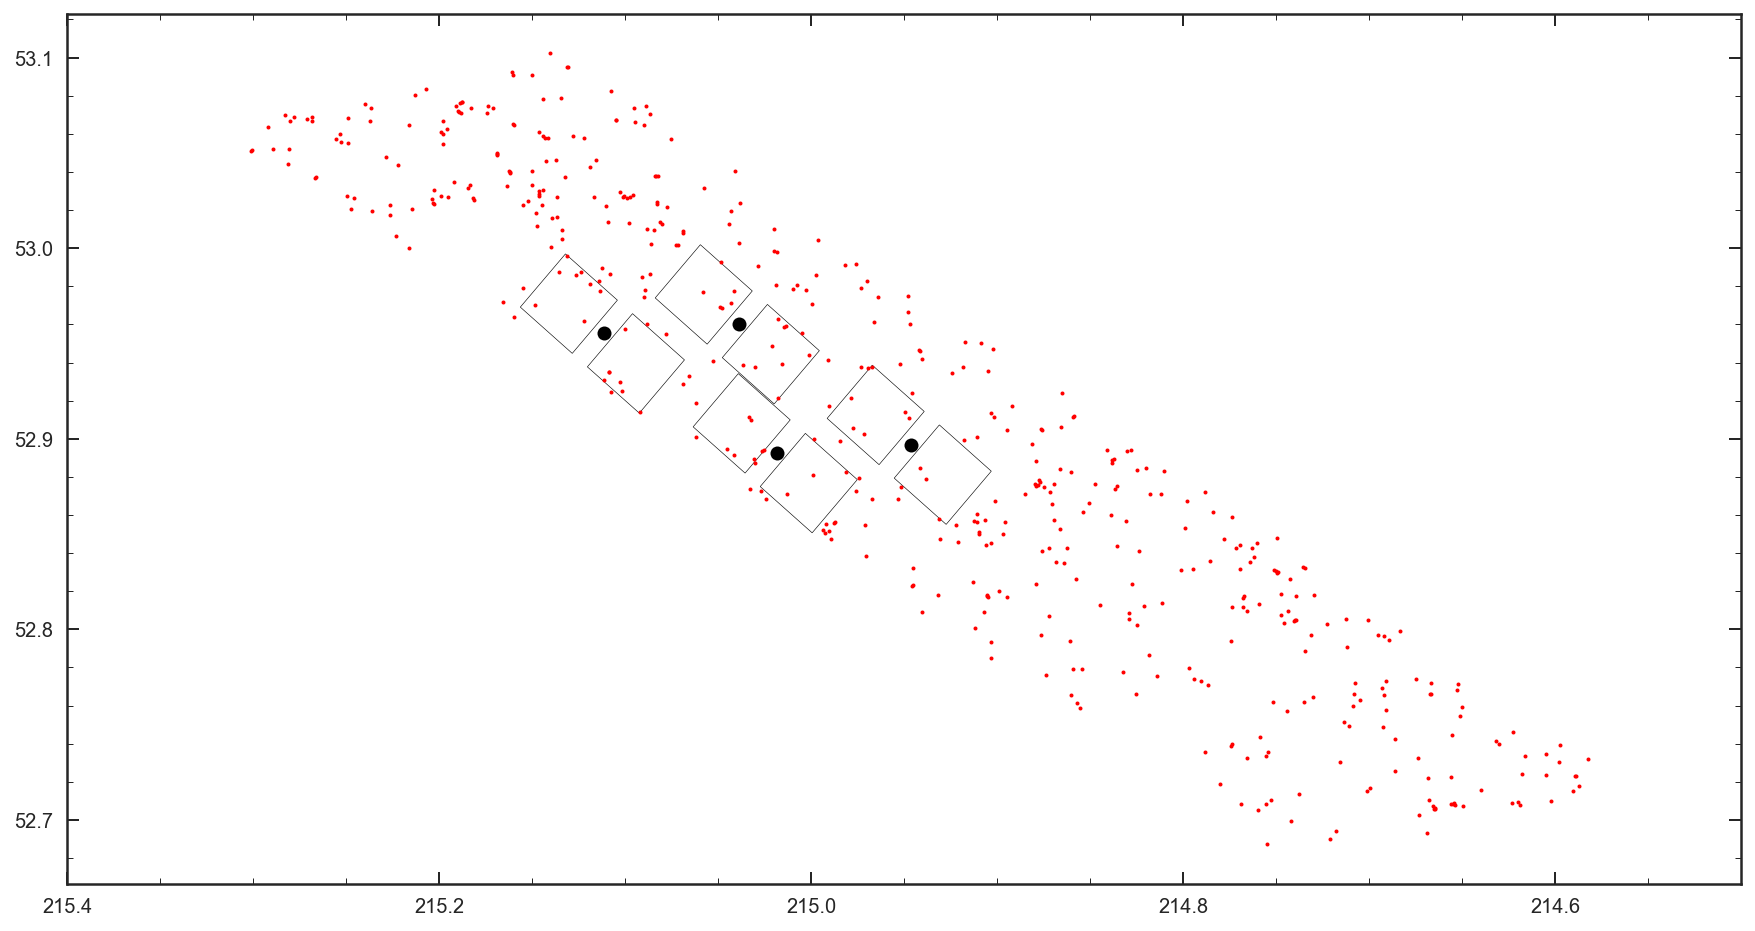

In [139]:
fig2 = plt.figure(figsize=[15,8])
ax2 = fig2.add_subplot(111)#,aspect='equal')
plt.plot(qDF['ra'], qDF['dec'] ,'ro',ms=2)

# plt.plot(215.111550,52.95528,'kD')
# plt.plot(215.0390267,52.96011,'kD')
# plt.plot(215.0186304,52.89246,'kD')
# plt.plot(214.9465871,52.89689,'kD')

for i in range(len(P)):
    plt.plot(P[i][0],P[i][1],'ko')

for i in range(4):
    ax2.add_patch(patches.Rectangle((sPb[i][0],sPb[i][1]),0.037,0.037,fill=False,angle=311))
    ax2.add_patch(patches.Rectangle((tPb[i][0],tPb[i][1]),0.037,0.037,fill=False,angle=311))

plt.xlim(215.4,214.5)


In [69]:
129./60/60

0.035833333333333335

In [120]:
2.2/60.

0.03666666666666667

In [123]:
5.1-4.4

0.6999999999999993

In [124]:
0.7/60

0.011666666666666665

In [126]:
43./60/60

0.011944444444444445